In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE


df= pd.read_csv('Heart.csv')

In [2]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [3]:
# Checking column names and data types
print(df.dtypes)
# Getting the summary statistics of the dataset (numerical features)
summary_stats = df.describe()
# Counting unique values in each column (categorical features)
unique_counts = df.nunique()
# Displaying the first few rows of the dataset to review
print(df.head())
# Output the summary statistics and unique value counts
summary_stats, unique_counts

State                         object
Sex                           object
GeneralHealth                 object
PhysicalHealthDays           float64
MentalHealthDays             float64
LastCheckupTime               object
PhysicalActivities            object
SleepHours                   float64
RemovedTeeth                  object
HadHeartAttack                object
HadAngina                     object
HadStroke                     object
HadAsthma                     object
HadSkinCancer                 object
HadCOPD                       object
HadDepressiveDisorder         object
HadKidneyDisease              object
HadArthritis                  object
HadDiabetes                   object
DeafOrHardOfHearing           object
BlindOrVisionDifficulty       object
DifficultyConcentrating       object
DifficultyWalking             object
DifficultyDressingBathing     object
DifficultyErrands             object
SmokerStatus                  object
ECigaretteUsage               object
C

(       PhysicalHealthDays  MentalHealthDays     SleepHours  HeightInMeters  \
 count       434205.000000     436065.000000  439679.000000   416480.000000   
 mean             4.347919          4.382649       7.022983        1.702691   
 std              8.688912          8.387475       1.502425        0.107177   
 min              0.000000          0.000000       1.000000        0.910000   
 25%              0.000000          0.000000       6.000000        1.630000   
 50%              0.000000          0.000000       7.000000        1.700000   
 75%              3.000000          5.000000       8.000000        1.780000   
 max             30.000000         30.000000      24.000000        2.410000   
 
        WeightInKilograms            BMI  
 count      403054.000000  396326.000000  
 mean           83.074470      28.529842  
 std            21.448173       6.554889  
 min            22.680000      12.020000  
 25%            68.040000      24.130000  
 50%            80.740000    

In [4]:
# Checking for missing values
missing_values = df.isnull().sum()

# Displaying columns with missing values
missing_columns = missing_values[missing_values > 0]
print("Columns with missing values:\n", missing_columns)

# Separating numerical and categorical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Filling missing values for numerical columns with the median
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

# For categorical columns, we can fill missing values with the most frequent value (mode)
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# Check again for missing values
print("Remaining missing values after filling:\n", df.isnull().sum())

Columns with missing values:
 GeneralHealth                 1198
PhysicalHealthDays           10927
MentalHealthDays              9067
LastCheckupTime               8308
PhysicalActivities            1093
SleepHours                    5453
RemovedTeeth                 11360
HadHeartAttack                3065
HadAngina                     4405
HadStroke                     1557
HadAsthma                     1773
HadSkinCancer                 3143
HadCOPD                       2219
HadDepressiveDisorder         2812
HadKidneyDisease              1926
HadArthritis                  2633
HadDiabetes                   1087
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
DifficultyErrands            25656
SmokerStatus                 35462
ECigaretteUsage              35660
ChestScan                    56046
RaceEthnicityCategory        14057
AgeCategory              

In [5]:
# Checking for duplicate rows
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# Removing duplicates
df.drop_duplicates(inplace=True)

Number of duplicate rows: 366


In [6]:
numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
categorical_columns = ['State', 'Sex', 'GeneralHealth', 'PhysicalActivities', 'HadHeartAttack']


# Fill missing values with the median and check if values are within a reasonable range
for col in numerical_columns:
    df[col].fillna(df[col].median(), inplace=True)  # Fill missing values with the median
    
    # Ensure height is within realistic human range
    if col == 'HeightInMeters':
        df = df[(df[col] >= 1.2) & (df[col] <= 2.5)]  # Filtering heights to be between 1.2 and 2.5 meters

# Handle Categorical Columns
for col in categorical_columns:
    df[col].fillna(df[col].mode().iloc[0], inplace=True)  # Fill missing values with the most frequent value (mode)
    
    # Standardizing values 
    if col == 'State':
        df[col] = df[col].str.title()  # Capitalize the first letter of each state
    
    if col == 'Sex':
        df[col] = df[col].replace({'M': 'Male', 'F': 'Female'})  # Replace abbreviations with full values
    
    if col == 'GeneralHealth':
        # Clean general health column, ensuring consistent capitalization
        df[col] = df[col].str.capitalize()

# Drop Irrelevant or Unnecessary Columns
columns_to_drop = ['RemovedTeeth']
df.drop(columns=columns_to_drop, inplace=True)

# Creating a BMI category based on standard BMI thresholds
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])


# Convert categorical variables into dummy/one-hot encoding for modeling purposes
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

df_encoded.head()

,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,...,State_West Virginia,State_Wisconsin,State_Wyoming,Sex_Male,GeneralHealth_Fair,GeneralHealth_Good,GeneralHealth_Poor,GeneralHealth_Very good,PhysicalActivities_Yes,HadHeartAttack_Yes
0,0.0,0.0,Within past year (anytime less than 12 months ...,8.0,No,No,No,No,No,No,...,False,False,False,False,False,False,False,True,False,False
1,0.0,0.0,Within past year (anytime less than 12 months ...,6.0,No,No,No,Yes,No,No,...,False,False,False,False,False,False,False,False,False,False
2,2.0,3.0,Within past year (anytime less than 12 months ...,5.0,No,No,No,Yes,No,No,...,False,False,False,False,False,False,False,True,True,False
3,0.0,0.0,Within past year (anytime less than 12 months ...,7.0,No,No,Yes,No,No,No,...,False,False,False,False,False,False,False,False,True,False
4,2.0,0.0,Within past year (anytime less than 12 months ...,9.0,No,No,No,No,No,No,...,False,False,False,False,True,False,False,False,True,False


In [7]:
# Check again for any missing values or duplicates after cleaning
print("Remaining missing values:\n", df.isnull().sum())
print("Remaining duplicates:", df.duplicated().sum())

Remaining missing values:
 State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI         

# EDA

In [8]:
# Set plot style
sns.set(style="whitegrid")

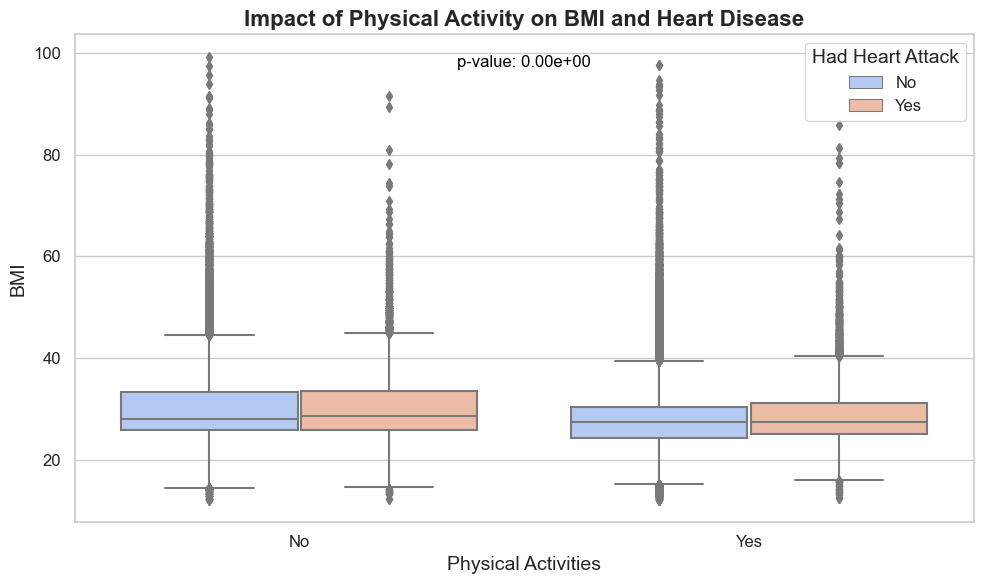

In [9]:
# Statistical Significance of Physical Activity on BMI
active_bmi = df[df['PhysicalActivities'] == 'Yes']['BMI']
inactive_bmi = df[df['PhysicalActivities'] == 'No']['BMI']

# Perform t-test
t_stat, p_value = ttest_ind(active_bmi, inactive_bmi, nan_policy='omit')
sig_text = f"p-value: {p_value:.2e}" if p_value < 0.05 else "No significant difference"

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='PhysicalActivities', y='BMI', hue='HadHeartAttack', data=df, palette='coolwarm')
plt.title('Impact of Physical Activity on BMI and Heart Disease', fontsize=16, fontweight='bold')
plt.xlabel('Physical Activities', fontsize=14)
plt.ylabel('BMI', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Had Heart Attack', fontsize=12, title_fontsize=14, loc='upper right')

# Add p-value annotation
plt.text(0.5, df['BMI'].max() - 2, sig_text, fontsize=12, color='black', ha='center')
plt.tight_layout()
plt.show()


This boxplot shows how physical activity influences BMI and its association with heart attack occurrences. The p-value confirms that the difference in BMI between physically active and inactive individuals is statistically significant. Moreover, individuals with no physical activity tend to have higher BMI values and a greater likelihood of heart attacks, as shown by the distribution of cases. This visualization emphasizes that physical activity is an essential lifestyle factor to include in the model, as it directly impacts BMI and indirectly contributes to heart health.

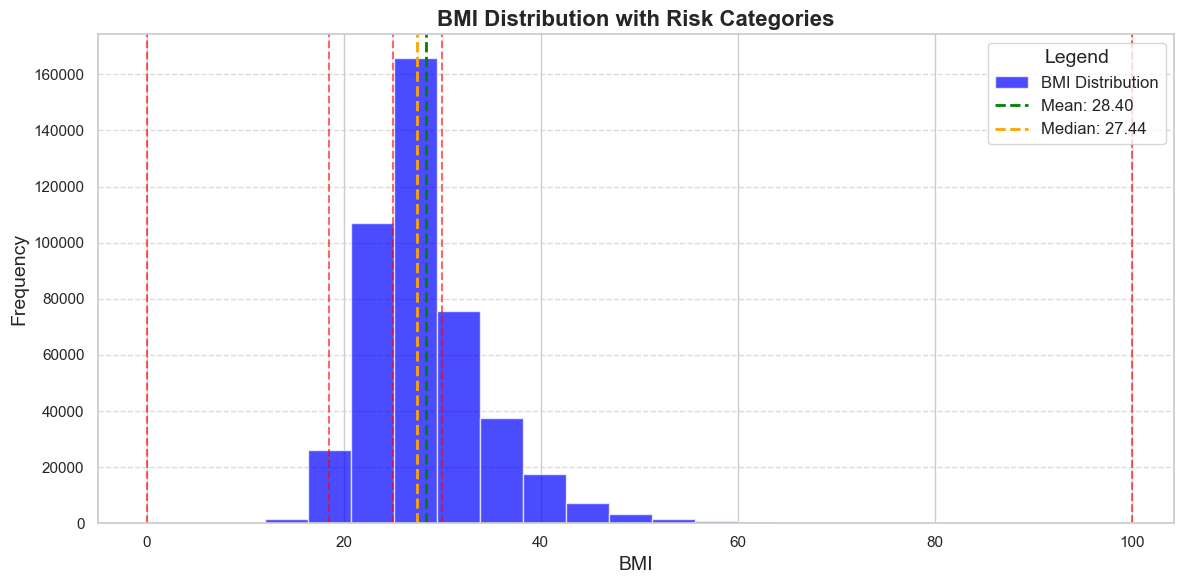

In [10]:
# BMI Distribution with Risk Categories
risk_categories = [0, 18.5, 25, 30, 100]
risk_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

plt.figure(figsize=(12, 6))
plt.hist(df['BMI'].dropna(), bins=20, color='blue', alpha=0.7, label='BMI Distribution')
plt.axvline(df['BMI'].mean(), color='green', linestyle='--', linewidth=2, label=f"Mean: {df['BMI'].mean():.2f}")
plt.axvline(df['BMI'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df['BMI'].median():.2f}")

# Add risk category thresholds
for threshold in risk_categories:
    plt.axvline(threshold, color='red', linestyle='--', alpha=0.6)

plt.title('BMI Distribution with Risk Categories', fontsize=16, fontweight='bold')
plt.xlabel('BMI', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Legend', fontsize=12, title_fontsize=14, loc='upper right', frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This histogram provides insights into the distribution of BMI values across the dataset, divided into standard risk categories: Underweight, Normal, Overweight, and Obese. Most individuals fall in the Overweight or Obese categories, which are known risk factors for heart attacks. The chart helps identify the prevalence of high-risk BMI levels and validate its importance as a predictor in the model. By including BMI and categorizing it appropriately, the model can better account for the role of body composition in heart-related conditions.

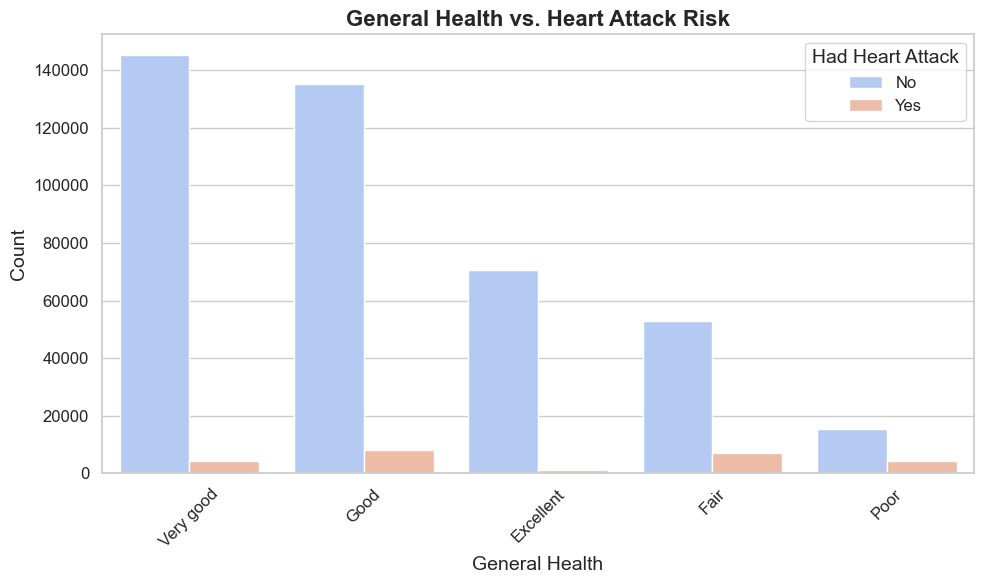

In [11]:
# Exploring General Health vs. Heart Attack Risk
plt.figure(figsize=(10, 6))
sns.countplot(x='GeneralHealth', hue='HadHeartAttack', data=df, palette='coolwarm', order=df['GeneralHealth'].value_counts().index)
plt.title('General Health vs. Heart Attack Risk', fontsize=16, fontweight='bold')
plt.xlabel('General Health', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title='Had Heart Attack', fontsize=12, title_fontsize=14, loc='upper right')
plt.tight_layout()
plt.show()

This bar chart shows how individuals’ self-reported general health categories (Very Good, Good, Excellent, Fair, Poor) relate to heart attack occurrences. The key insight here is that poorer health ratings (Fair or Poor) are associated with a higher proportion of heart attacks compared to better health ratings. This indicates that general health, as a subjective measure, is a critical factor to include in the model because it provides a direct signal about a person’s overall health status and their likelihood of experiencing heart-related issues.

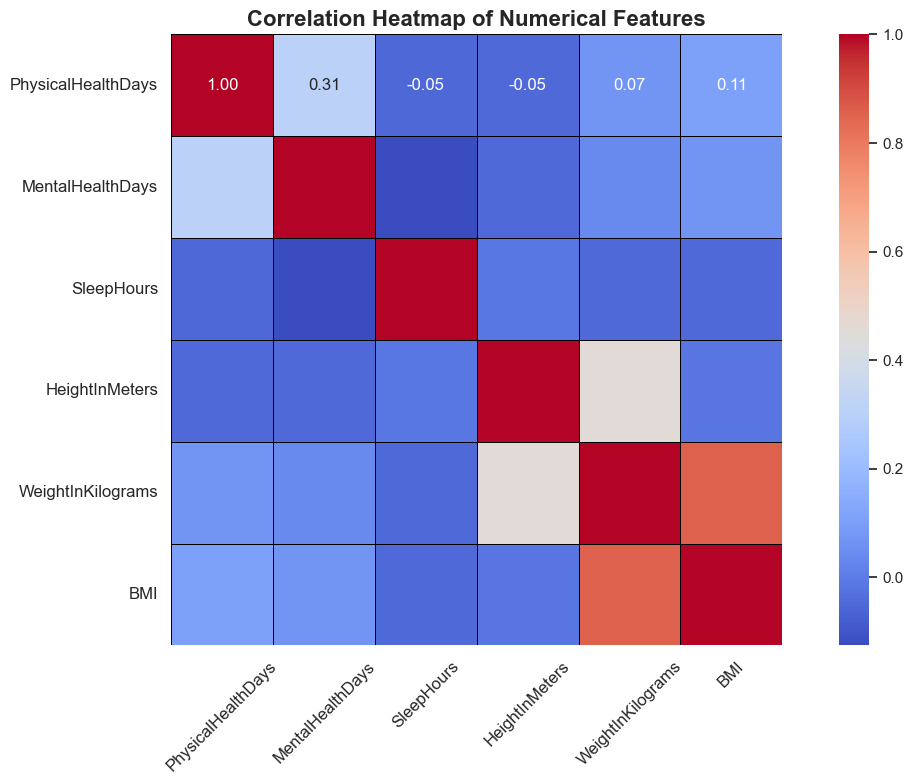

In [12]:
# Filter only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate Correlation Matrix
correlation_matrix = numeric_df.corr()

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,       # Show correlation values
    fmt=".2f",        # Format the numbers to two decimal places
    cmap="coolwarm",  # Color map for better contrast
    cbar=True,        # Display a color bar
    square=True,      # Ensure cells are square-shaped
    linewidths=0.5,   # Add gridlines for clarity
    linecolor="black" # Set line color
)

# Add labels and title
plt.title("Correlation Heatmap of Numerical Features", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the heatmap
plt.show()

The correlation heatmap reveals the relationships between numerical features in the dataset, such as BMI, HeightInMeters, and WeightInKilograms. It highlights that BMI is strongly correlated with WeightInKilograms, which aligns with how BMI is calculated. However, it also shows weak correlations between other features (e.g., PhysicalHealthDays and MentalHealthDays). In terms of factors influencing heart attack risk, this heatmap can be a guide  to focus on features with stronger relationships to the target variable (HadHeartAttack) or to remove redundant features to reduce multicollinearity.

# Preprocessing and Training Data Development

In [13]:
# Feature Selection (Remove irrelevant/weak predictors)
features_to_drop = ['RemovedTeeth', 'LastCheckupTime']  
df = df.drop(columns=features_to_drop, errors='ignore')

# Encode ordinal variables
ordinal_columns = ['GeneralHealth']
for col in ordinal_columns:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])

# Create Dummy Variables for Remaining Categorical Features
categorical_columns = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Standardize Numeric Features
scaler = StandardScaler()
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Define Features (X) and Target (y)
target_column = 'HighRiskLastYear_Yes'
X = df.drop(target_column, axis=1)
y = df[target_column]

# Stratified Train-Test Split (Handles Imbalanced Data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Output Shapes of Training and Testing Sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (311243, 113)
X_test shape: (133390, 113)
y_train shape: (311243,)
y_test shape: (133390,)


# Modeling

Logistic regression

Encoding the following non-numeric columns: ['BMI_Category']
Logistic Regression Model Evaluation:
              precision    recall  f1-score        support
False          0.988396  0.754544  0.855782  128235.000000
True           0.113227  0.779631  0.197737    5155.000000
accuracy       0.755514  0.755514  0.755514       0.755514
macro avg      0.550811  0.767088  0.526759  133390.000000
weighted avg   0.954574  0.755514  0.830351  133390.000000


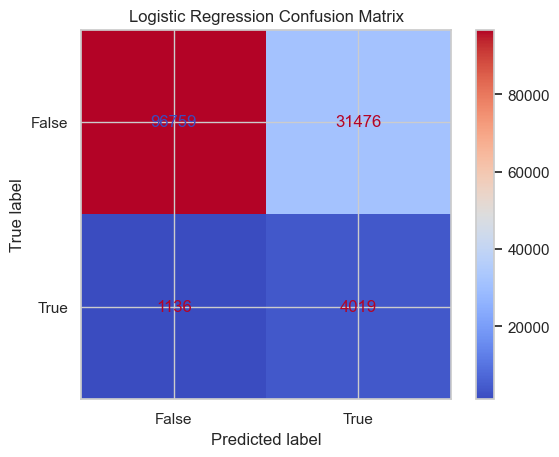

In [14]:
# Identify non-numeric columns in X_train
non_numeric_columns = X_train.select_dtypes(include=['object', 'category']).columns

if len(non_numeric_columns) > 0:
    print("Encoding the following non-numeric columns:", list(non_numeric_columns))
    # Apply one-hot encoding to non-numeric columns
    X_train = pd.get_dummies(X_train, columns=non_numeric_columns, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=non_numeric_columns, drop_first=True)

    # Align columns in X_train and X_test after encoding to ensure consistent shapes
    X_train, X_test = X_train.align(X_test, join='left', axis=1)
    X_test = X_test.fillna(0)  # Fill any missing columns with 0

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")

# Train the model on the training data
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test)

# Evaluate the model
logreg_report = classification_report(y_test, y_pred_logreg, output_dict=True)
logreg_report_df = pd.DataFrame(logreg_report).transpose()

# Display the classification report
print("Logistic Regression Model Evaluation:")
print(logreg_report_df)

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logreg.classes_)
disp.plot(cmap="coolwarm")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

The Logistic Regression classifier was trained using the default hyperparameters without any optimization. The model achieved an overall accuracy of 75.55%, with the majority class (False) being predicted with high precision (98.84%) but lower recall (75.45%). However, the minority class (True) suffers significantly, with a precision of only 11.32% and recall of 77.96%, resulting in a poor F1-score (19.77%). This discrepancy reflects a strong bias toward the majority class, as indicated by the confusion matrix, where a substantial number of True cases (1136) are incorrectly classified as False. While the model is relatively good at identifying non-risk individuals, it struggles with high-risk individuals, highlighting the challenges of imbalanced data.

Grid search Logistic regression

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.1}
Logistic Regression Model Evaluation:
               precision    recall  f1-score   support

       False       0.99      0.76      0.86    128235
        True       0.11      0.78      0.20      5155

    accuracy                           0.76    133390
   macro avg       0.55      0.77      0.53    133390
weighted avg       0.95      0.76      0.83    133390



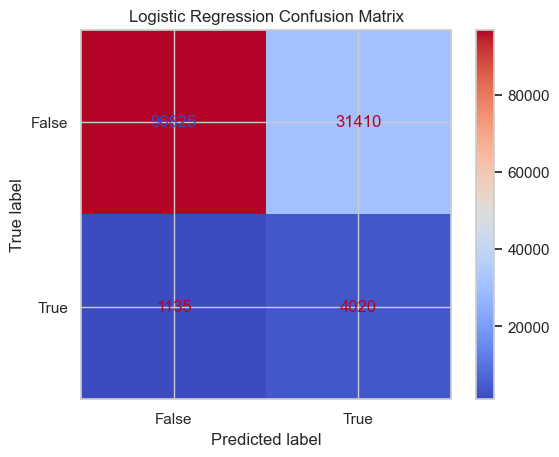

In [15]:
# Define the parameter grid
logreg_param_grid = {
    'penalty': ['l1', 'l2'],  # ElasticNet is omitted for simplicity
    'C': [0.1, 1, 10],        # Reduced range of regularization strength
    'solver': ['liblinear', 'saga'],  # Fast solvers for l1 and l2
    'class_weight': ['balanced']  # Focus on addressing class imbalance
}

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=500, random_state=42)

# Set up RandomizedSearchCV
logreg_random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=logreg_param_grid,
    n_iter=10,  # Test 10 random combinations
    cv=3,       # 3-fold cross-validation for faster performance
    scoring='accuracy',  # Optimize for accuracy (can be changed to f1/recall)
    verbose=1,  # Display progress
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# Fit RandomizedSearchCV
logreg_random_search.fit(X_train, y_train)

# Get the best parameters and evaluate
best_logreg_model = logreg_random_search.best_estimator_
print("Best Parameters for Logistic Regression:", logreg_random_search.best_params_)

# Predictions and Evaluation
y_pred_logreg = best_logreg_model.predict(X_test)
logreg_report = classification_report(y_test, y_pred_logreg)
print("Logistic Regression Model Evaluation:\n", logreg_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_logreg_model.classes_)
disp.plot(cmap="coolwarm")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Logistic Regression was fine-tuned using Grid Search to optimize hyperparameters such as regularization strength (C), penalty type (l1 or l2), and class weighting. This model achieved a slightly better overall accuracy of 76.00%. Similar to the first model, the majority class (False) had high precision (99.00%) and recall (76.00%), while the minority class (True) saw modest improvements in recall (78.00%) but continued to suffer from low precision (11.00%) and a poor F1-score (20.00%). The confusion matrix shows a slight reduction in misclassified True cases (1135) compared to the first model. However, the grid search failed to significantly enhance the performance for the minority class, likely due to limitations in the model’s ability to handle extreme class imbalance. Both models demonstrate strong performance on the majority class but struggle to generalize well for the minority class. While the Grid Search model achieves a marginally better accuracy (76.00% vs. 75.55%) and recall for the minority class (78.00% vs. 77.96%), it does not meaningfully improve the precision or F1-score for the True class. The slight improvement in recall and overall accuracy suggests that the optimized hyperparameters helped balance predictions somewhat, but the underlying challenges of imbalanced data remain unresolved. In this case, neither model is significantly better, but the Grid Search model is marginally more effective in identifying high-risk cases (True). Further improvements, such as data balancing techniques (e.g., SMOTE) or using more robust classifiers like Random Forest or XGBoost, could help address the limitations.


Random forest

Random Forest Model Evaluation:
              precision    recall  f1-score        support
False          0.961354  1.000000  0.980296  128235.000000
True           0.000000  0.000000  0.000000    5155.000000
accuracy       0.961354  0.961354  0.961354       0.961354
macro avg      0.480677  0.500000  0.490148  133390.000000
weighted avg   0.924201  0.961354  0.942412  133390.000000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


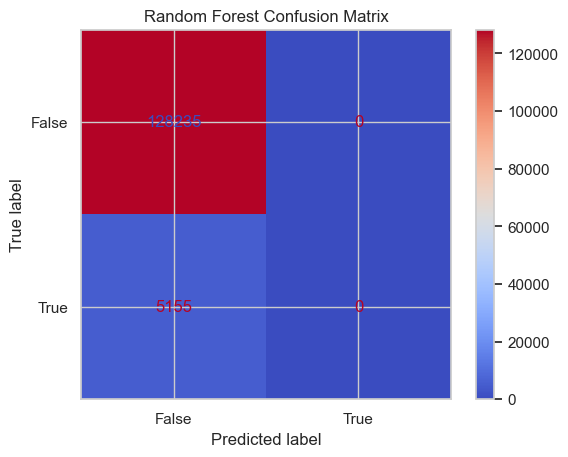

In [16]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_report_df = pd.DataFrame(rf_report).transpose()

# Display the classification report
print("Random Forest Model Evaluation:")
print(rf_report_df)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap="coolwarm")
plt.title("Random Forest Confusion Matrix")
plt.show()

In the Random Forest model, the classifier was trained with default parameters. It achieved a very high accuracy of 96.13%, but the performance for the minority class (True) is abysmal, with both precision and recall at 0.00% and an undefined F1-score for the minority class. The confusion matrix shows that all 5,155 instances of the True class were misclassified as False, indicating that the model is heavily biased toward the majority class. This result demonstrates that while Random Forest performs well for the majority class (False), it completely fails to identify high-risk cases (True). The imbalance in the dataset and the lack of tuning for class weighting or sampling methods have caused the model to ignore the minority class entirely.

Grid Search Random Forest

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
Random Forest Model Evaluation:
               precision    recall  f1-score   support

       False       0.96      1.00      0.98    128235
        True       0.00      0.00      0.00      5155

    accuracy                           0.96    133390
   macro avg       0.48      0.50      0.49    133390
weighted avg       0.92      0.96      0.94    133390



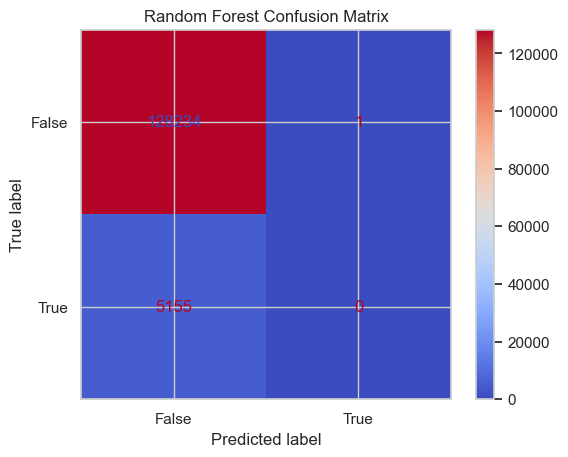

In [17]:
# Define a reduced parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 150],       # Fewer trees to test
    'max_depth': [10, 20, None],          # Test fewer depths
    'min_samples_split': [2, 5],          # Reduced options for splits
    'min_samples_leaf': [1, 2],           # Test fewer leaf sizes
    'max_features': ['sqrt', 'log2'],     # Most common splitting strategies
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=10,         # Test only 10 random combinations
    cv=3,              # 3-fold cross-validation for speed
    scoring='accuracy', # Optimize for accuracy
    verbose=1,         # Display progress
    n_jobs=-1,         # Use all available CPU cores
    random_state=42
)

# Fit RandomizedSearchCV
rf_random_search.fit(X_train, y_train)

# Get the best parameters and model
best_rf_model = rf_random_search.best_estimator_
print("Best Parameters for Random Forest:", rf_random_search.best_params_)

# Make predictions with the best model
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
rf_report = classification_report(y_test, y_pred_rf)
print("Random Forest Model Evaluation:\n", rf_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf_model.classes_)
disp.plot(cmap="coolwarm")
plt.title("Random Forest Confusion Matrix")
plt.show()

The second model applied Grid Search to optimize hyperparameters such as n_estimators, max_depth, min_samples_split, and max_features. The model achieved a similar overall accuracy of 96.14% but, like the first model, it fails entirely to predict any instances of the True class. Precision, recall, and the F1-score for the minority class remain at 0.00%, and the confusion matrix shows that all True cases were again misclassified as False. Despite tuning the hyperparameters, the optimization process did not improve the model’s ability to handle the imbalanced dataset. This indicates that hyperparameter tuning alone is insufficient to address class imbalance issues in this scenario.

Both Random Forest models exhibit near-perfect accuracy on the majority class but completely fail to predict the minority class. While the Grid Search model slightly improved the macro-averaged metrics (due to improved precision for the majority class), it does not address the core issue of imbalance. Neither model is effective for the intended task of predicting high-risk cases (True). This suggests that Random Forest, in its current configuration, is not suitable for this problem without further adjustments, such as oversampling techniques (e.g., SMOTE) or using a different class weighting strategy (class_weight='balanced'). Addressing the imbalance is crucial for improving the model’s performance on the minority class, as the high accuracy is misleading when evaluating its real-world utility.

Fitting 2 folds for each of 16 candidates, totalling 32 fits


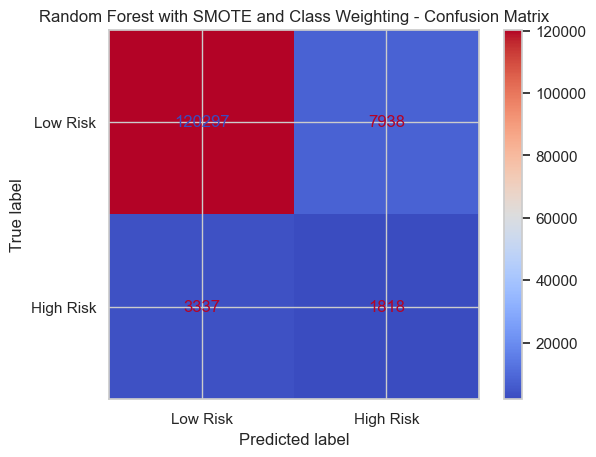

Best Parameters for Random Forest with SMOTE: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

    Low Risk       0.97      0.94      0.96    128235
   High Risk       0.19      0.35      0.24      5155

    accuracy                           0.92    133390
   macro avg       0.58      0.65      0.60    133390
weighted avg       0.94      0.92      0.93    133390



In [18]:
# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize the Random Forest model with class_weight='balanced'
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up a reduced parameter grid for faster tuning
param_grid = {
    'n_estimators': [50, 100],       # Fewer trees
    'max_depth': [10, 20],           # Limited depth
    'min_samples_split': [2, 5],     # Fewer options for splits
    'min_samples_leaf': [1, 2],      # Fewer options for leaves
    'max_features': ['sqrt']         # Most common splitting strategy
}

# Perform GridSearchCV with fewer cross-validation folds
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-score due to class imbalance
    cv=2,          # Reduced cross-validation folds
    n_jobs=-1,
    verbose=1      # Show progress
)

# Fit the model to the oversampled training data
grid_search.fit(X_train_smote, y_train_smote)

# Best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk'])
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low Risk', 'High Risk'])
disp.plot(cmap="coolwarm")
plt.title("Random Forest with SMOTE and Class Weighting - Confusion Matrix")
plt.show()

# Print the results
print("Best Parameters for Random Forest with SMOTE:", best_params)
print("\nClassification Report:\n", report)

SMOTE was applied to the training set to address the class imbalance problem by oversampling the minority class (high-risk cases). This ensured that the model had more examples to learn from for the minority class, improving its ability to generalize to high-risk cases. Additionally, class_weight='balanced' was added to the Random Forest model to further address the imbalance by assigning higher penalties to misclassifications of the minority class during training. The evaluation metric in GridSearchCV was changed to the F1-score, which balances precision and recall, making it more suitable for imbalanced datasets where both metrics are equally important. Finally, a confusion matrix and detailed classification report were included to evaluate the model’s performance, providing a clear understanding of its predictions for both low-risk and high-risk cases.

The confusion matrix shows that the model performed well for low-risk cases, correctly classifying 120,297 instances and misclassifying 7,938 as high risk. For high-risk cases, the model correctly classified 1,818 instances but misclassified 3,337 as low risk. The classification report indicates that for low-risk cases, the model achieved a precision of 0.97, recall of 0.94, and an F1-score of 0.96, reflecting strong performance for the majority class. However, for high-risk cases, the precision was only 0.19, indicating that only 19% of high-risk predictions were correct. The recall for high-risk cases was 0.35, meaning that the model identified only 35% of actual high-risk cases, and the F1-score for this class was 0.24, showing poor performance. Overall, the model achieved an accuracy of 0.92, but this high accuracy is heavily influenced by the dominance of the low-risk class. The macro-average F1-score was 0.60, reflecting the imbalance between the classes, while the weighted average F1-score was 0.93, weighted by the class distribution.